In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1609498703000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600 * 24

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low       Volume
0     2021-01-01 19:59:59   736.82   738.85   741.76   736.11  29384.09871
1     2021-01-01 20:59:59   738.85   733.19   743.33   732.12  50190.47228
2     2021-01-01 21:59:59   733.19   740.08   741.99   733.00  23543.56362
3     2021-01-01 22:59:59   740.08   738.00   742.67   736.46  22098.37395
4     2021-01-01 23:59:59   738.01   735.39   740.00   733.50  25671.61199
...                   ...      ...      ...      ...      ...          ...
6995  2023-03-13 10:59:59  1599.22  1589.30  1601.89  1583.64  66770.32430
6996  2023-03-13 11:59:59  1589.29  1588.43  1595.56  1584.45  28313.52130
6997  2023-03-13 12:59:59  1588.42  1594.93  1602.29  1587.84  47660.92580
6998  2023-03-13 13:59:59  1594.94  1599.48  1600.63  1593.30  17147.08310
6999  2023-03-13 14:59:59  1599.48  1601.91  1606.00  1593.92  24533.90460

[7000 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 14, 50):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff()

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low       Volume  \
0     2021-01-01 19:59:59   736.82   738.85   741.76   736.11  29384.09871   
1     2021-01-01 20:59:59   738.85   733.19   743.33   732.12  50190.47228   
2     2021-01-01 21:59:59   733.19   740.08   741.99   733.00  23543.56362   
3     2021-01-01 22:59:59   740.08   738.00   742.67   736.46  22098.37395   
4     2021-01-01 23:59:59   738.01   735.39   740.00   733.50  25671.61199   
...                   ...      ...      ...      ...      ...          ...   
6995  2023-03-13 10:59:59  1599.22  1589.30  1601.89  1583.64  66770.32430   
6996  2023-03-13 11:59:59  1589.29  1588.43  1595.56  1584.45  28313.52130   
6997  2023-03-13 12:59:59  1588.42  1594.93  1602.29  1587.84  47660.92580   
6998  2023-03-13 13:59:59  1594.94  1599.48  1600.63  1593.30  17147.08310   
6999  2023-03-13 14:59:59  1599.48  1601.91  1606.00  1593.92  24533.90460   

            ema_8       ema_14       ema_50        atr      slo

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_14']
        # c4
        df['c4'] = df['ema_14'] >= df['ema_50']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_14,ema_50,atr,slowk,slowd,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2021-01-01 19:59:59,736.82,738.85,741.76,736.11,29384.09871,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2021-01-01 20:59:59,738.85,733.19,743.33,732.12,50190.47228,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
2,2021-01-01 21:59:59,733.19,740.08,741.99,733.00,23543.56362,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
3,2021-01-01 22:59:59,740.08,738.00,742.67,736.46,22098.37395,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
4,2021-01-01 23:59:59,738.01,735.39,740.00,733.50,25671.61199,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,2023-03-13 10:59:59,1599.22,1589.30,1601.89,1583.64,66770.32430,1568.791226,1544.209443,1490.870354,22.768379,80.692294,87.044687,False,False,True,True,True,False,True
6996,2023-03-13 11:59:59,1589.29,1588.43,1595.56,1584.45,28313.52130,1573.155398,1550.105517,1494.696223,21.935637,80.187859,82.490745,False,False,True,True,True,False,False
6997,2023-03-13 12:59:59,1588.42,1594.93,1602.29,1587.84,47660.92580,1577.994199,1556.082115,1498.626959,21.400949,83.956630,81.612261,True,True,True,True,True,True,False
6998,2023-03-13 13:59:59,1594.94,1599.48,1600.63,1593.30,17147.08310,1582.768821,1561.868499,1502.581980,20.395881,86.308184,83.484224,False,False,True,True,True,False,True


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = buydf['Close']
atr_val = buydf['atr']

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price
        # set stop loss
        # 進場
    
    elif buydf.at[index, 'openbuy'] == True:
   
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = close_val.shift(1).at[index] - 3 * atr_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = buydf.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (buydf.at[index, 'High'] >= close_val.shift(1).at[index] + 2 * atr_val.shift(1).at[index]) and in_position == True:
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low        Volume  \
49    2021-01-03 20:59:59   829.77   831.47   835.86   826.38   55214.58488   
50    2021-01-03 21:59:59   831.46   874.21   888.33   831.46  180985.66008   
51    2021-01-03 22:59:59   874.17   912.38   921.73   862.30  261568.37752   
52    2021-01-03 23:59:59   912.39   917.72   920.00   879.52  200326.60168   
53    2021-01-04 00:59:59   917.95   935.26   978.00   917.72  323944.90322   
...                   ...      ...      ...      ...      ...           ...   
6993  2023-03-13 08:59:59  1580.33  1611.88  1622.60  1573.07  113644.66140   
6994  2023-03-13 09:59:59  1611.89  1599.23  1614.19  1597.49   42419.98470   
6995  2023-03-13 10:59:59  1599.22  1589.30  1601.89  1583.64   66770.32430   
6997  2023-03-13 12:59:59  1588.42  1594.93  1602.29  1587.84   47660.92580   
6998  2023-03-13 13:59:59  1594.94  1599.48  1600.63  1593.30   17147.08310   

            ema_8       ema_14       ema_50        

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_14', 'ema_50', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low        ema_8  \
0    2021-01-03 21:59:59   831.46   874.21   888.33   831.46   828.171122   
1    2021-01-03 22:59:59   874.17   912.38   921.73   862.30   846.884206   
2    2021-01-03 23:59:59   912.39   917.72   920.00   879.52   862.625494   
3    2021-01-04 00:59:59   917.95   935.26   978.00   917.72   878.766495   
4    2021-01-04 01:59:59   935.26   935.54   958.21   917.00   891.382830   
..                   ...      ...      ...      ...      ...          ...   
976  2023-03-13 01:59:59  1462.43  1514.98  1521.98  1461.62  1471.854223   
977  2023-03-13 02:59:59  1514.98  1532.10  1548.80  1512.00  1485.242173   
978  2023-03-13 04:59:59  1512.58  1541.09  1546.99  1510.72  1502.376130   
979  2023-03-13 05:59:59  1541.10  1541.12  1542.35  1532.19  1510.985879   
980  2023-03-13 06:59:59  1541.11  1564.31  1594.19  1527.33  1522.835683   

          ema_14       ema_50        atr kd_cross position  entry_p  \
0   

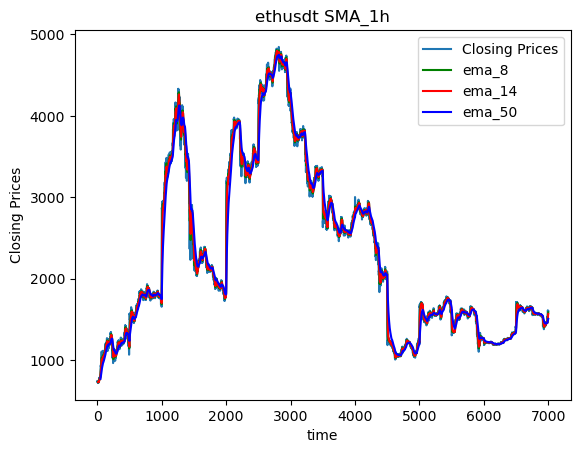

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')

plt.plot(df.ema_8, label='ema_8', c='g')
plt.plot(df.ema_14, label='ema_14', c='r')
plt.plot(df.ema_50, label='ema_50', c='b')
plt.legend()
plt.show()